<div align="center"><h1>Control Engineering Basics</h1>
<br><b>Dr.Varodom Toochinda</b>
<br>Dept. of Mechanical Engineering, Kasetsart University</div>

### Supplement to Module 4,6,7 : Discrete-time PID class implementation

<a href="https://colab.research.google.com/github/dewdotninja/control_python/blob/master/adv_pid_class_implement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Requirement : </b> Python 3 with Python control systems library
<p />Execute the commands below to install Python control systems library in Colab    

In [ ]:
!pip install control

In [1]:
import control as ctl 
import numpy as np
import matplotlib.pyplot as plt

### Discrete-time implementation of PID controller

Figure 1 shows a Scilab/Xcos diagrom of PID controller with added features such as setpoint weightings 
and back calculation antiwindup scheme.

!["Fig 1"](https://drive.google.com/uc?id=1qVcZcbnwI0NLe1gCW6Ze7PKiVBUlFify)

Figure 1 PID controller with all features 

Here we show how to implement this PID using object-oriented programming, which can be simulated 
in this notebook, or implemented in embedded system that supports Python (or micropython). 

Define a PID class as follows.

In [50]:
# PID controller class
class PID:
    def __init__(self,kp,ki,kd,kt,n,wp,wd,ts):
        # PID parameters
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.kt = kt
        self.n = n
        self.wp = wp
        self.wd = wd
        self.ts = ts
        
        # coefficients
        self.bi = 0.5*self.ts*self.ki
        self.bt = 0.5*self.ts*self.kt
        ad1 = 1+0.5*self.n*self.ts
        ad2 = 0.5*self.n*self.ts - 1
        self.ad = -ad2/ad1
        self.bd = self.kd*self.n/ad1

        # controller states
        self.e1 = 0
        self.e0 = 0
        self.ed1 = 0
        self.ed0 = 0
        self.eus1 = 0
        self.eus0 = 0
        self.up0 = 0
        self.ui1 = 0
        self.ui0 = 0
        self.ud1 = 0
        self.ud0 = 0
        self.u = 0
        self.ulim = 0

        # controller output limits
        self.output_limit = True
        self.umax = 1000  # some default values
        self.u_offset = False
    # get & set output limit
    def getulim(self):
        return self.umax
    def setulim(self,umax):
        self.umax = umax
    def getulimstatus(self):
        return self.output_limit
    def enableulim(self):
        self.output_limit = True
    def disableulim(self):
        self.output_limit = False

    # get & enable/disable output offset
    def getoffsetstatus(self):
        return self.u_offset
    def enableoffset(self):
        self.output_limit = True # need to use output limit
        self.u_offset = True 
    def disableoffset(self):
        self.u_offset = False
        
    # parameter getters & setters 
    def getkp(self):
        return self.kp
    def getki(self):
        return self.ki
    def getkd(self):
        return self.kd
    def getkt(self):
        return self.kt
    def getn(self):
        return self.n
    def getwp(self):
        return self.wp
    def getwd(self):
        return self.wd
    def getts(self):
        return self.ts
    def getparms(self):
        parms = np.array([self.kp,self.ki,self.kd,self.kt,self.n,self.wp,self.wd,self.ts])
        return parms

    def setkp(self,kp):
        self.kp = kp
    def setki(self,ki):
        self.ki = ki
    def setkd(self,kd):
        self.kd = kd
    def setkt(self,kt):
        self.kt = kt
    def setn(self,n):
        self.n = n
    def setwp(self,wp):
        self.wp = wp
    def setwd(self,wd):
        self.wd = wd
    def setts(self,ts):
        self.ts = ts
    def setparms(self,parms):
        self.kp = parms[0]
        self.ki = parms[1]
        self.kd = parms[2]
        self.kt = parms[3]
        self.n = parms[4]
        self.wp = parms[5]
        self.wd = parms[6]
        self.ts = parms[7]
   
    # coefficient update
    def update(self):
        self.bi = 0.5*self.ts*self.ki
        self.bt = 0.5*self.ts*self.kt
        ad1 = 1+0.5*self.n*self.ts
        ad2 = 0.5*self.n*self.ts - 1
        self.ad = -ad2/ad1
        self.bd = self.kd*self.n/ad1
        
    # reset controller states
    def reset(self):
        self.e1 = 0
        self.e0 = 0
        self.ed1 = 0
        self.ed0 = 0
        self.eus1 = 0
        self.eus0 = 0
        self.up0 = 0
        self.ui1 = 0
        self.ui0 = 0
        self.ud1 = 0
        self.ud0 = 0
        self.u = 0
        self.ulim = 0

    def out(self,r,y):
        # state transfer
        self.e1 = self.e0
        self.ed1 = self.ed0
        self.eus1 = self.eus0
        
        self.ui1 = self.ui0
        self.ud1 = self.ud0
        # compute errors for each term
        self.e0 = r - y
        self.ep0 = self.wp*r - y # weighted proportional error
        self.ed0 = self.wd*r - y # weighted derivative error
        
        self.up0 = self.kp*self.ep0 # output of P term
        self.ui0 = self.ui1 +self.bi*(self.e0+self.e1) + self.bt*(self.eus0+self.eus1) # output of I term
        self.ud0 = self.ad*self.ud1 +self.bd*(self.ed0 - self.ed1) # output of D term
        self.u = self.up0 + self.ui0 + self.ud0        
        self.ulim = self.u
        if self.output_limit:
            if self.u_offset:  # offset to half of self.umax
                UMID = 0.5*self.umax
                if self.u > UMID:
                    self.eus0 = UMID - self.u  # compute error for back calculation term
                    self.ulim = UMID         # limit u to UMID
                elif self.u < -UMID:
                    self.eus0 = -self.u - UMID  # compute error for back calculation term
                    self.ulim = -UMID         # limit u to -UMID
                self.ulim += UMID
            else:
                if self.u > self.umax:
                    self.eus0 = self.umax - self.u  # compute error for back calculation term
                    self.ulim = self.umax         # limit u to umax
                elif self.u < -self.umax:
                    self.eus0 = -self.u - self.umax  # compute error for back calculation term
                    self.ulim = -self.umax         # limit u to -umax                
        return self.ulim        

In [4]:
# parameters tuned using ZNFD method
Kp = 4.8
Ki = 2.6
Kd = 2.2
Kt = 0.0
N = 50
Wp = 1
Wd = 1
Ts = 0.01

Create a PID instance.

In [51]:
pid = PID(Kp,Ki,Kd,Kt,N,Wp,Wd,Ts)

Create a third-order lag plant 
$$
P(s) = \frac{1}{(s+1)^3}
$$

to be used in the simulation.

In [7]:
s = ctl.tf("s")
P = 1/(s+1)**3
P

TransferFunction(array([1]), array([1, 3, 3, 1]))

This cell below demonstrates how to simulate in a timer loop.  

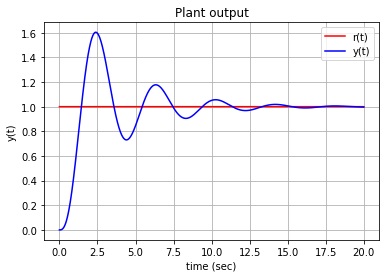

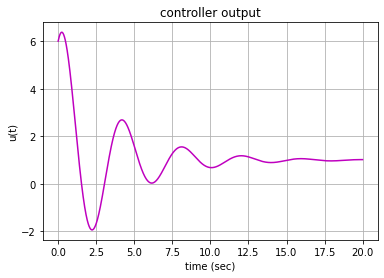

In [57]:
Pd = ctl.sample_system(P, Ts, method='tustin')
#print("Discrete-time plant")
#print(Pd)

Pdnum, Pdden = ctl.tfdata(Pd)
#print(Pdnum)
#print(Pdden)
pdnum = np.squeeze(np.array(Pdnum))
pdden = np.squeeze(np.array(Pdden))
tvec = np.arange(0,20,Ts)  # change time scale to suit
rvec = np.ones(tvec.shape)
yvec = np.zeros(tvec.shape)
uvec = np.zeros(tvec.shape)
numorder = len(pdnum)  # 4 for this example
denorder = len(pdden)  # 4
y_prev = np.zeros((denorder,1)) 
u_prev = np.zeros((numorder,1))
i = 0
# perform discrete-time simulation 
for i in range(len(tvec)):

    for k in range(numorder-1):
        u_prev[k] = u_prev[k+1]
    for k in range(denorder-1):
        y_prev[k] = y_prev[k+1]
        

    # ----- PID controller ---------
    uvec[i] = pid.out(rvec[i],yvec[i-1])
    # --------------------------------------

    # plant simulation 
    u_prev[numorder-1] = uvec[i]        
    yvec[i] = pdnum[0]*uvec[i]
    for k in range(denorder-1):
        yvec[i] = yvec[i]+pdnum[k+1]*u_prev[numorder-2-k] - pdden[k+1]*y_prev[denorder-2-k]
    y_prev[denorder-1] = yvec[i]
    
# plot the result

plt.figure()
plt.plot(tvec, rvec,'r-',tvec,yvec,'b-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('y(t)')
plt.legend(['r(t)','y(t)'])

plt.title("Plant output")

plt.figure()
plt.plot(tvec,uvec,'m-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('u(t)')
plt.title("controller output")

plt.show()

Use this cell to adjust PID parameters and rerun the simulation above.

In [56]:
Kp = 6
Ki = 3
Kd = 2.2
Kt = 0.5
Wp = 1
Wd = 0
N = 100
# Ts = 0.001 # you need to adjust time step in the simulation time vector accordingly
pid.setparms([Kp,Ki,Kd,Kt,N,Wp,Wd,Ts])
pid.update()
pid.reset()

<h3>References</h3>
<ol>
<li>K.J. Astrom and T.Hagglund. PID Controllers, 2nd ed., Instrument Society of America, 1995.</li>
<li>V. Toochinda. Digital PID Controllers,  2009. </li>
</ol>

<div align="right">Last update : October 17, 2022</div>

<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja<br>Copyright 2021</div>